In [118]:
#Différents imports
from pymatgen import Structure
from pymatgen.symmetry.analyzer import PointGroupAnalyzer
from pymatgen.symmetry.analyzer import SpacegroupOperations
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.operations import SymmOp  
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from jupyter_jsmol.pymatgen import quick_view
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.bandstructure import *
from pymatgen.electronic_structure.plotter import *
import matplotlib.pyplot as plt
import numpy as np

In [119]:
#Téléchargement du fichier CIF

with MPRester("1fhLOrkpiXoSTmqx") as m :
    structure = m.get_structure_by_material_id("mp-30847") # ID du TiSnPt
    structure_band =  m.get_bandstructure_by_material_id("mp-30847")


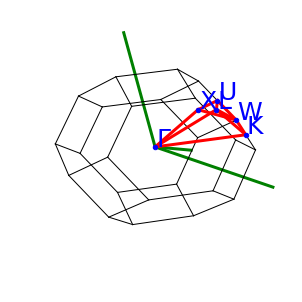

In [120]:
info = BSPlotter(structure_band )
info.plot_brillouin()
#Zone étudier

# Question 1 :
Déterminer la bande interdite

In [121]:
bande = structure_band.get_band_gap()
direct = "direct"
if(bande[direct]==False):
    direct = "indirect"
energie = str(bande['energy'])
transition = str(bande['transition'])
print(" La bande d'énergie est " + direct + " la valeur de cette bande est de "+energie+ "eV et le label de points k de la transition est "+transition + ".")

 La bande d'énergie est indirect la valeur de cette bande est de 0.7910000000000004eV et le label de points k de la transition est \Gamma-X.


# Question 2 :
Trouver la direction dans laquelle la dernière bande de valence présente le plus et le moins de dispersion et la direction dans laquelle première bande de conduction présente le plus et le moins de dispersion

In [122]:
# Recherche de la premiere et de la dernière bande devalence et de conduction 

bande_cond = structure_band.get_cbm()
bande_val = structure_band.get_vbm()
ind_cond = bande_cond["band_index"].items()
ind_val = bande_val["band_index"].items()
list_cond = []
list_val = []
for i in ind_cond:
    list_cond.append(i[1][0])
for j in ind_val:
    list_val.append(j[1][0])

d_val = list_val[-1]
p_cond = list_cond[0]


print("La première bande de conduction est donc la bande "+ str(p_cond))
print("La dernière bande de valence est donc la bande "+str(d_val))


La première bande de conduction est donc la bande 17
La dernière bande de valence est donc la bande 14


In [123]:
# Recherche de la dispersion

# Recherche de la pente 
def calcul_pente(a,b):
    c = abs(a[-1] - a[0]) /( b[-1] - b[0])
    return np.array([a[-1],a[0],b[-1],b[0],c])

data = info.bs_plot_data()
dist = data.get('ticks').get('distance')
distances = data.get('distances')
ener = data.get('energy')

def dispersions (d):
    pente = np.zeros((len(distances),5))
    pp = np.zeros(len(distances))
    for i in range (len(distances)):
        pente [i] = calcul_pente(ener["1"][i][d],distances[i])
        
    for j in range (len(distances)):
        pp [j] = pente[j][4]
    return [pente,pp]


max_val = np.argmax(dispersions(d_val)[1])
min_val = np.argmin(dispersions(d_val)[1])
max_cond = np.argmax(dispersions(d_cond)[1])
min_cond = np.argmin(dispersions(d_cond)[1])


La pente max pour la bande de valence est égal à 3.7684819124886144 (en vert).
La pente max pour la bande de conduction est égal à 1.0582775692453326 (en rouge).


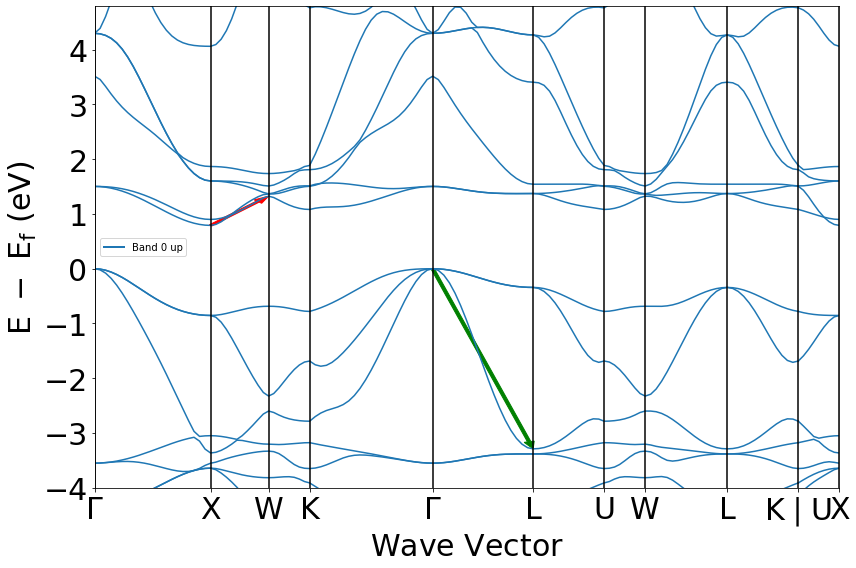

In [124]:
# Recherche des pentes max pour la bande de valence et de conduction 


info.get_plot()
pente_val_max = dispersions(d_val)[0][max_val]
plt.arrow(pente_val_max[3],pente_val_max[1],pente_val_max[2]-pente_val_max[3],pente_val_max[0]-pente_val_max[1],color='green', width = 0.03,length_includes_head = True)
print("La pente max pour la bande de valence est égal à "+ str(pente_val_max[4])+ " (en vert).")

pente_cond_max = dispersions(d_cond)[0][max_cond]
plt.arrow(pente_cond_max[3],pente_cond_max[1],pente_cond_max[2]-pente_cond_max[3],pente_cond_max[0]-pente_cond_max[1],color = 'red',width =0.03, length_includes_head = True)
print("La pente max pour la bande de conduction est égal à "+ str(pente_cond_max[4])+ " (en rouge).")

La pente min pour la bande de valence est égal à 0.5209452337628746 (en vert).
La pente min pour la bande de conduction est égal à 0.06788839341443945 (en rouge).


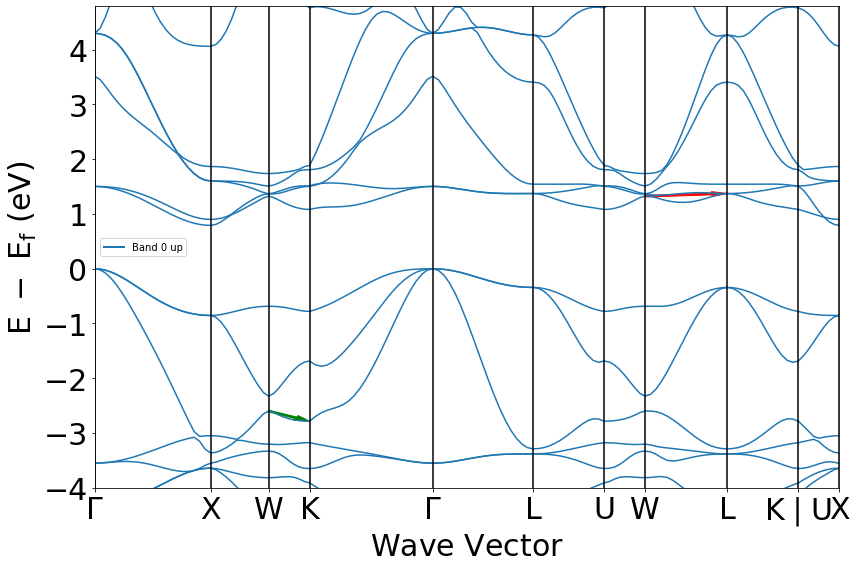

In [125]:
# Recherche des pentes min pour la bande de valence et de conduction 


info.get_plot()
pente_val_min = dispersions(d_val)[0][min_val]
plt.arrow(pente_val_min[3],pente_val_min[1],pente_val_min[2]-pente_val_min[3],pente_val_min[0]-pente_val_min[1],color='green', width = 0.03,length_includes_head = True)

print("La pente min pour la bande de valence est égal à "+ str(pente_val_min[4])+ " (en vert).")

pente_cond_min = dispersions(d_cond)[0][min_cond]
plt.arrow(pente_cond_min[3],pente_cond_min[1],pente_cond_min[2]-pente_cond_min[3],pente_cond_min[0]-pente_cond_min[1],color = 'red',width =0.03, length_includes_head = True)
print("La pente min pour la bande de conduction est égal à "+ str(pente_cond_min[4])+ " (en rouge).")

# Question 3 :
Calculer la masse effective au sommet (base) de la dernière (première) bande de valence (conduction) en supposant une dispersion parabolique.

Formule de la masse effective : $E(k) = E_0 + \frac{ \hbar^2k^2}{2m*} $

In [126]:
# Calcul de hbar en [eV]
cst_plank_bar = (6.62607015*10**(-34))/(2*np.pi)
eV = 1.602176634*10**(-19)
hbar = cst_plank_bar/eV 

# Interpolation pour la bande de valence 
bande_val = data.get('vbm')
k_val = np.zeros(3)
k_val[1]= bande_val[0][0]
k_val[0]= distances[4][-2]
k_val[2]=distances[5][1]

e_val = np.zeros(3)
e_val[1] = bande_val[0][1]
e_val[0] = ener.get('1')[4][11][-2]
e_val[2] = ener.get('1')[5][11][1]


interpol_bval = np.polyfit(k_val,e_val,2)
masse_eff = (bande_val[0][0])**2*(hbar**2/(2*interpol_bval[0]))
print("La masse effective pour la bande de valence est de "+str(masse_eff)+ "kg.")
# j'obtiens 0kg pour la masse effective de la bande de la valence, ce qui m'étonne beaucoup mais je ne trouve pas mon erreur 



# Interpolation pour la bande de conduction 
bande_cond = data.get('cbm')
k_cond = np.zeros(3)
k_cond[1]= bande_cond[0][0]
k_cond[0]= distances[4][-2]
k_cond[2]=distances[5][1]

e_cond = np.zeros(3)
e_cond[1] = bande_cond[0][1]
e_cond[0] = ener.get('1')[4][11][-2]
e_cond[2] = ener.get('1')[5][11][1]


interpol_bcond = np.polyfit(k_cond,e_cond,2)
masse_eff = (bande_cond[0][0])**2*(hbar**2/(2*interpol_bcond[0]))
print("La masse effective pour la bande de valence est de "+str(masse_eff)+ "kg.")

La masse effective pour la bande de valence est de 0.0kg.
La masse effective pour la bande de valence est de 3.3206142942805912e-31kg.
